### Notes
1. Data Questions
    - Fit one peak or one trough
    - Fit to a sine wave
2. Nlinfit all simultaneously
    - Kappa_{mars} on all submerged sensors
    - all sensor depths
    - initial 'phase'
    - $\Delta T$ on top thermistor
3. Select Data
    - use best data
4. Detrend data on sensor
    - 1 fit or individual fits
    - polyfit(t,T,3?)
    - Might have to a trend for each thermistor
    - hopefully should level out when detrending
        - should still see some offset
5. UDF nlinfit 

### Theory
$ T(z,t) = T_0 + \Delta T e^{-z/\delta}\sin{(\frac{2\pi t}{\tau} - \frac{z}{\delta} + \phi)}$
- at z =0, it tells how big the fluctuation is
- $ \delta = \sqrt{\frac{\kappa \tau}{\pi}} =$ skin depth
- $\phi = $ phase offset
- $\tau =$ period
1. looking for
    - $\Delta T, \kappa, \vec{z}, \phi$

### Mars Information
- 669 sols on Mars
- 10 sec sol
    - $\tau = 669*10 $

In [2]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import datetime as dt
now = dt.datetime.now().strftime("%Y-%m-%d")
convSecYr = 1/6690

### Problem 1: Lab Data

In [1]:
import dataAcquisition as daq
from time import time,sleep
from scipy.io import savemat

In [ ]:
port = '/dev/ttyUSB0'
res = [9.88,10.04,9.83,10,9.97,10]
dur = 7200
step = 1

hal9001 = daq.DAQ(port,res,dur,step)

a = 9.57e-04
b = 3.15e-04
c = -1.17e-05
d = 6.23e-07

In [ ]:
start_time = time()
timepoints = []
view_time = 5
duration = dur
pause = step

run = True;

counter = 0
while run:
    timepoints.append(time()-start_time)
    current_time = timepoints[-1]
    
    j = 0
    for i in hal9001:
        temp = i.calcTemperature(i.calcResistance(i.readVoltage()),a,b,c,d)
        i.recoValue(counter,temp)
        j+=1
    counter+=1
    
    if(counter%300 == 0):
        hal9001.saveData()
        for i in hal9001:
            volt = i.readVoltage()
            res = i.calcResistance(volt)
            temp = i.calcTemperature(res,a,b,c,d)
            print(i,temp)
        
        
    if timepoints[-1] > duration:
        run=False
        
    sleep(pause)
    
hal9001.cleanData()
hal9001.saveData()

In [11]:
data = loadmat('20190305-2132data.mat')
channels = data['channels']
time = data['time'][0]

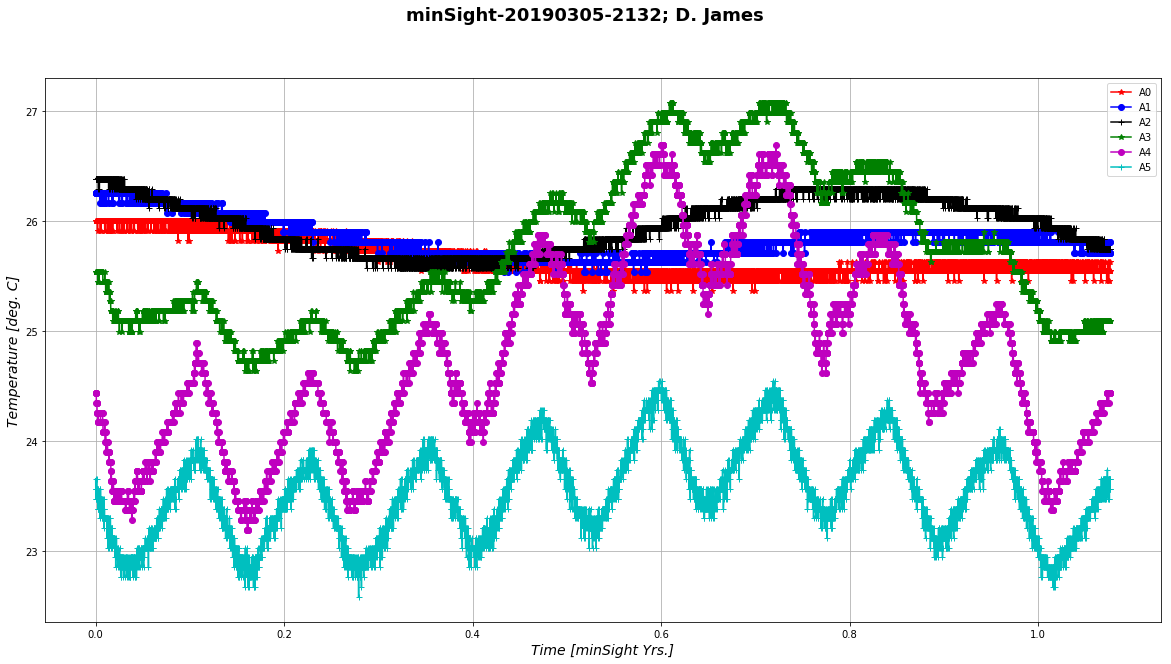

In [17]:
# plot all of the data you collected
fig2 = plt.figure(figsize=(20,10))
# http://matplotlib.org/users/text_props.html
fig2.suptitle('minSight-'+now+'; D. James', fontsize='18', fontweight='bold')
plt.xlabel('Time [minSight Yrs.]', fontsize='14', fontstyle='italic')
plt.ylabel('Temperature [deg. C]', fontsize='14', fontstyle='italic')
plt.axes().grid(True)

styles = ['r-*','b-o','k-+','g-*','m-o','c-+']
labels = ['A0','A1','A2','A3','A4','A5']

for i in range(0,len(channels)):
    plt.plot(time*convSecYr,channels[i],styles[i],label=labels[i])
    
plt.legend()
fig2.show()
fig2.savefig(now+'plot.png')

### Problem 2
- $T(z_i,t)=T_{0_i}+\Delta Te^{-(z_i-z_0)/\delta}\sin{(\frac{2 \pi t}{P}-\frac{z_i-z_0}{\delta} + \phi)}$
    - where $ \delta = \sqrt{\kappa P/\pi} $

In [3]:
data = loadmat('20190305-2132data.mat')
Temp = data['channels']
time = data['time'][0]
roomTemp = Temp[4:]
sandTemp = Temp[0:4]
z = [42e-3,28e-3,14e-3,0]

In [5]:
from numpy import exp,sin,pi,mean,sqrt,zeros

leng = sandTemp.shape[0]
meanTemp = zeros(leng)
for i in range(0,leng):
    meanTemp[i] = mean(Temp[i])

def T(z,t,T0):
    kappa = 3e-7
    z0 = 0
    P = 669*10
    delta = sqrt(kappa*P/pi)
    deltaT = 1.6
    
    return T0+deltaT*exp(-z/delta)*sin(2*pi*t/P-z/delta+7*pi/8)

In [6]:
theoryTemp = []

for i in range(0,leng):
    theoryTemp.append(T(z[i],time,meanTemp[i]))

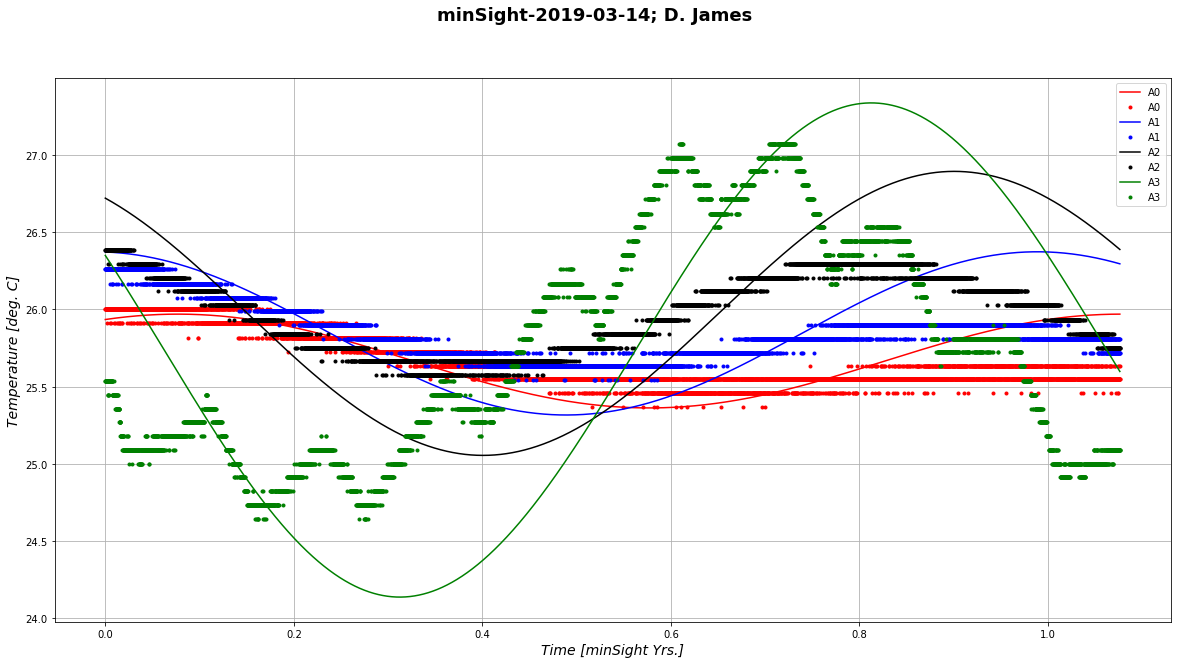

In [12]:
# plot all of the data you collected
fig3 = plt.figure(figsize=(20,10))
# http://matplotlib.org/users/text_props.html
fig3.suptitle('minSight-'+now+'; D. James', fontsize='18', fontweight='bold')
plt.xlabel('Time [minSight Yrs.]', fontsize='14', fontstyle='italic')
plt.ylabel('Temperature [deg. C]', fontsize='14', fontstyle='italic')
plt.axes().grid(True)

styles = ['r','b','k','g']
rawSty = ['r.','b.','k.','g.']
labels = ['A0','A1','A2','A3']

for i in range(0,leng):
    plt.plot(time*convSecYr,theoryTemp[i],styles[i],label=labels[i])
    plt.plot(time*convSecYr,sandTemp[i],rawSty[i],label=labels[i])
    
plt.legend()
fig3.show()
fig3.savefig(now+'plot2.png')

### Problem 3: Data Detrend
- pick the best window of data 
- don't need to start on a solstice
- did about a year of data 
- don't want to use the cubic polynomial for the one year
    - do it from start to the end of the window
    - different polynomial per sensor
    - subtract trend from data
- pick a period to invert

In [131]:
from numpy import polyval,polyfit

In [7]:
timeYear = time*convSecYr
timeIndex = timeYear > 0.4
windowTime = timeYear[timeIndex]
windowTemp = []
windowTheo = []

for i in range(0,leng):
    windowTemp.append(sandTemp[i][timeIndex])
    windowTheo.append(theoryTemp[i][timeIndex])

In [148]:
p = polyfit(windowTime,windowTemp[3],1)
polyTrend = polyval(p,windowTime)

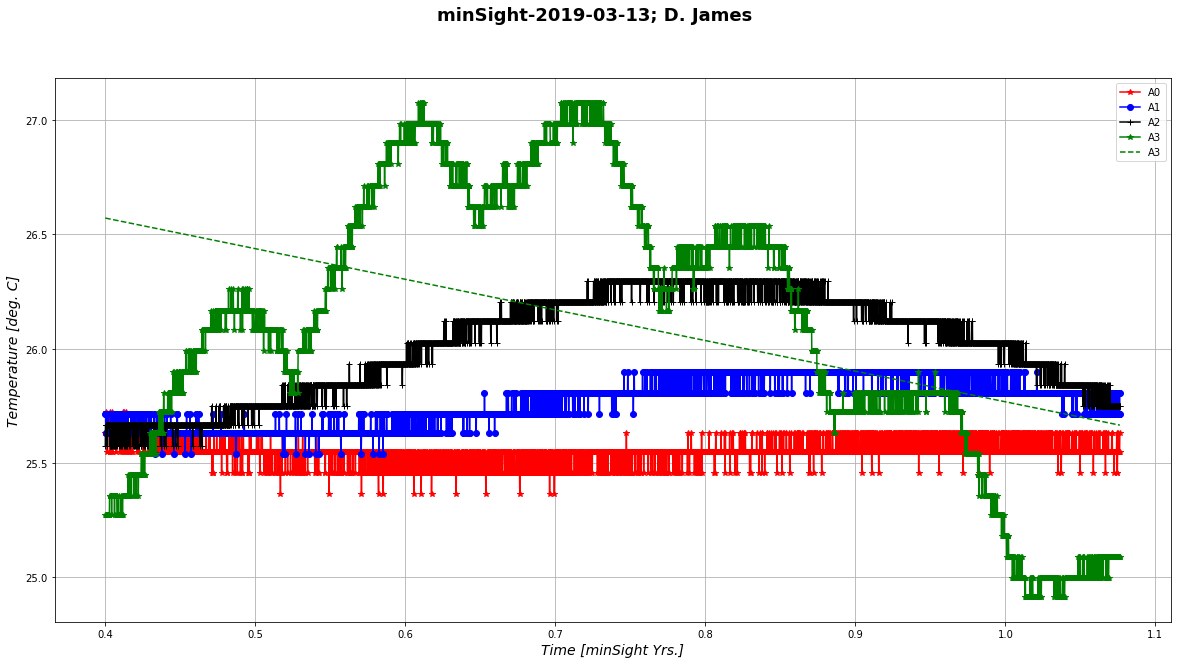

In [149]:
# plot all of the data you collected
fig4 = plt.figure(figsize=(20,10))
# http://matplotlib.org/users/text_props.html
fig4.suptitle('minSight-'+now+'; D. James', fontsize='18', fontweight='bold')
plt.xlabel('Time [minSight Yrs.]', fontsize='14', fontstyle='italic')
plt.ylabel('Temperature [deg. C]', fontsize='14', fontstyle='italic')
plt.axes().grid(True)

styles = ['r-*','b-o','k-+','g-*']
styles1= ['r--','b--','k--','g--']
labels = ['A0','A1','A2','A3']

for i in range(0,leng):
    plt.plot(windowTime,windowTemp[i],styles[i],label=labels[i])
plt.plot(windowTime,polyTrend,styles1[i],label=labels[i])
    
plt.legend()
fig4.show()
# fig3.savefig(now+'plot2.png')

In [141]:
tempDetrend = []

for i in range(0,leng):
    tempDetrend.append(windowTemp[i]-polyTrend[i])

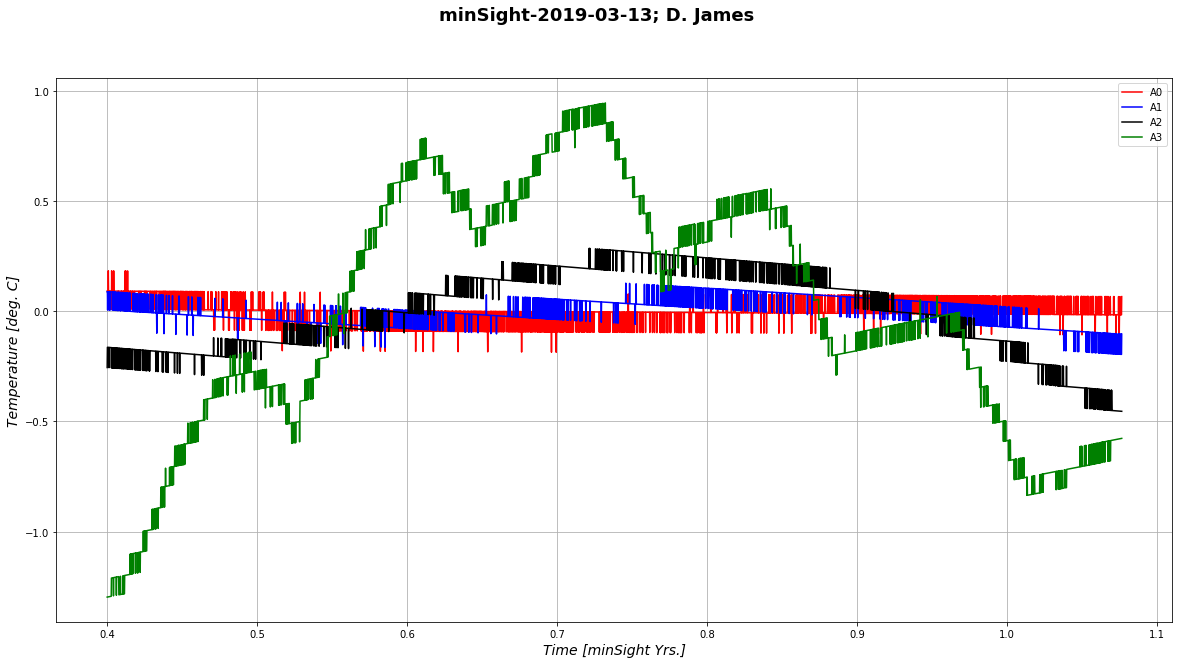

In [146]:
# plot all of the data you collected
fig5 = plt.figure(figsize=(20,10))
# http://matplotlib.org/users/text_props.html
fig5.suptitle('minSight-'+now+'; D. James', fontsize='18', fontweight='bold')
plt.xlabel('Time [minSight Yrs.]', fontsize='14', fontstyle='italic')
plt.ylabel('Temperature [deg. C]', fontsize='14', fontstyle='italic')
plt.axes().grid(True)

styles = ['r-*','b-o','k-+','g-*']
labels = ['A0','A1','A2','A3']

for i in range(0,leng):
    plt.plot(windowTime,tempDetrend[i],styles[i],label=labels[i])
        
plt.legend()
fig5.show()

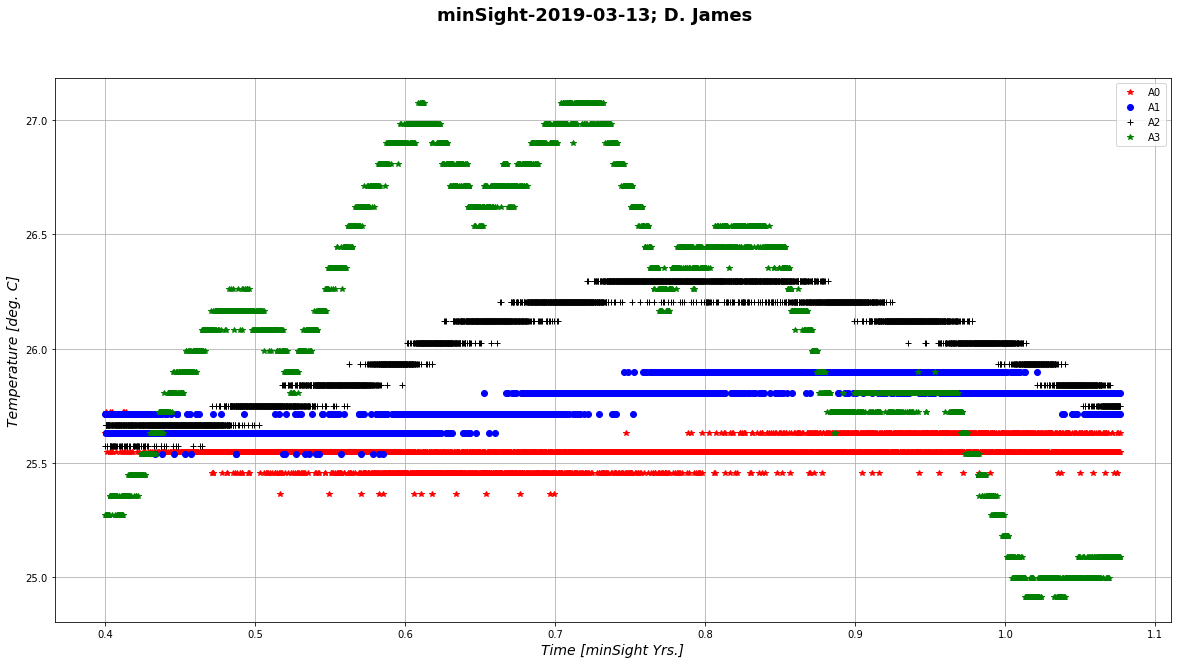

In [158]:
# plot all of the data you collected
fig6 = plt.figure(figsize=(20,10))
# http://matplotlib.org/users/text_props.html
fig6.suptitle('minSight-'+now+'; D. James', fontsize='18', fontweight='bold')
plt.xlabel('Time [minSight Yrs.]', fontsize='14', fontstyle='italic')
plt.ylabel('Temperature [deg. C]', fontsize='14', fontstyle='italic')
plt.axes().grid(True)

styles = ['r*','bo','k+','g*']
labels = ['A0','A1','A2','A3']

for i in range(0,leng):
    plt.plot(windowTime,windowTemp[i],styles[i],label=labels[i])
# plt.plot(windowTime,windowTemp[3]-polyTrend,styles[i],label=labels[i])
        
plt.legend()
fig6.show()

In [166]:
from scipy import signal

detrendTemp = []
for i in range(0,leng):
    detrendTemp.append(signal.detrend(windowTemp[i],type='constant'))

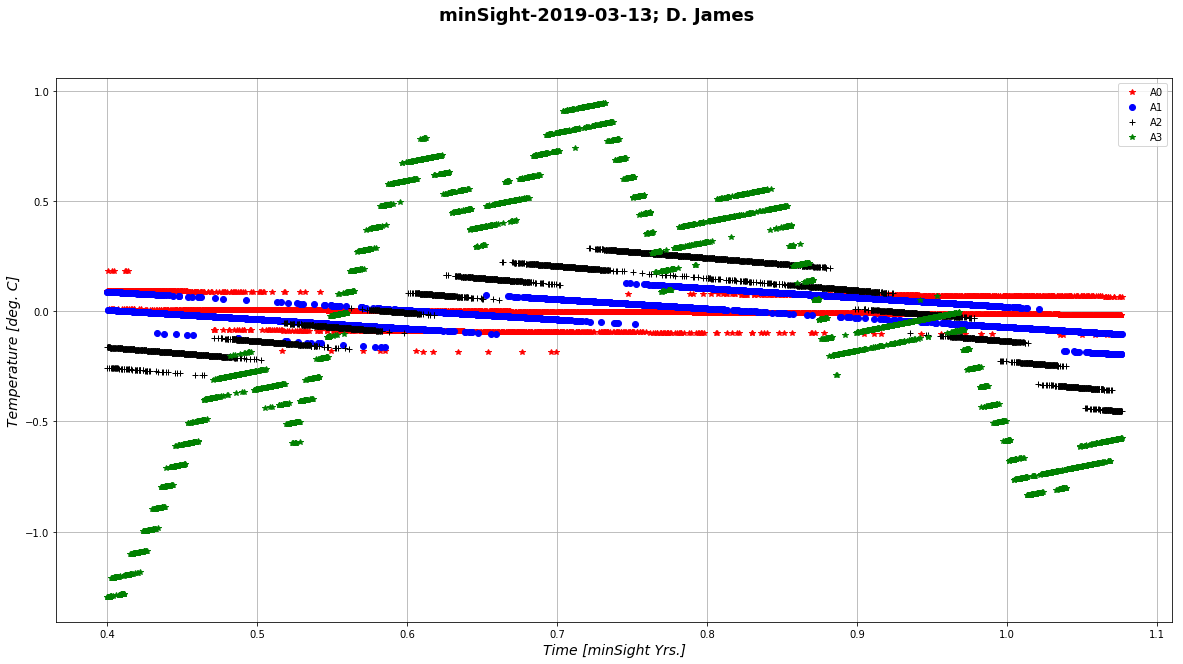

In [165]:
# plot all of the data you collected
fig7 = plt.figure(figsize=(20,10))
# http://matplotlib.org/users/text_props.html
fig7.suptitle('minSight-'+now+'; D. James', fontsize='18', fontweight='bold')
plt.xlabel('Time [minSight Yrs.]', fontsize='14', fontstyle='italic')
plt.ylabel('Temperature [deg. C]', fontsize='14', fontstyle='italic')
plt.axes().grid(True)

styles = ['r*','bo','k+','g*']
labels = ['A0','A1','A2','A3']

for i in range(0,leng):
    plt.plot(windowTime,detrendTemp[i],styles[i],label=labels[i])
# plt.plot(windowTime,windowTemp[3]-polyTrend,styles[i],label=labels[i])
        
plt.legend()
fig7.show()

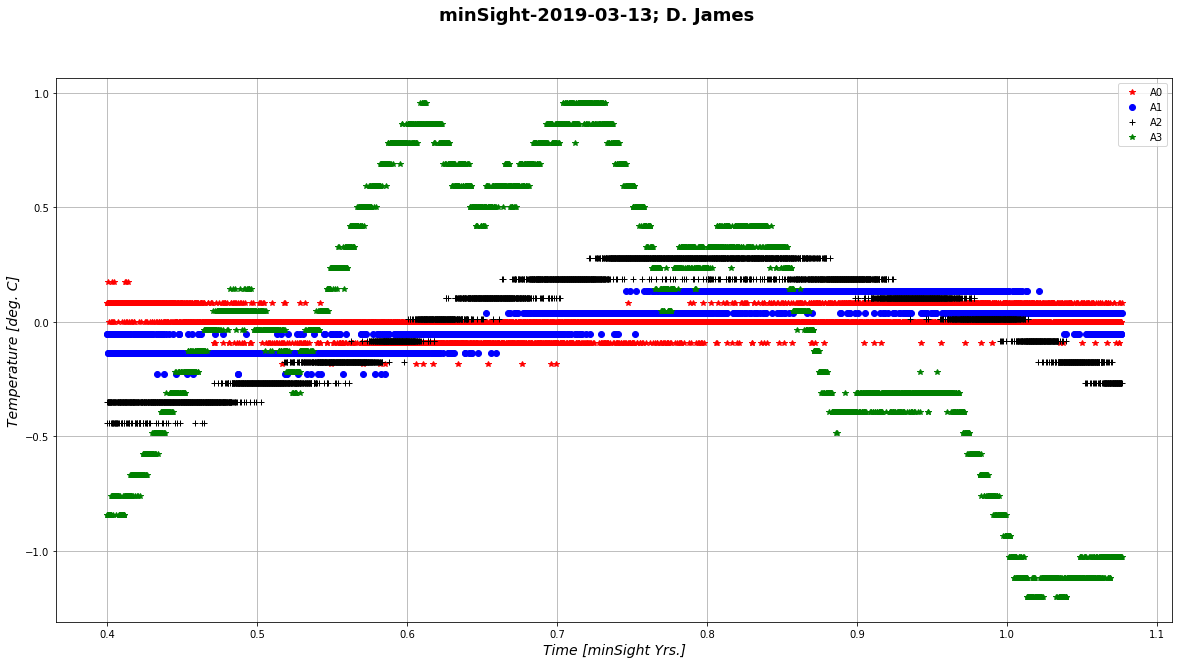

In [167]:
# plot all of the data you collected
fig7 = plt.figure(figsize=(20,10))
# http://matplotlib.org/users/text_props.html
fig7.suptitle('minSight-'+now+'; D. James', fontsize='18', fontweight='bold')
plt.xlabel('Time [minSight Yrs.]', fontsize='14', fontstyle='italic')
plt.ylabel('Temperature [deg. C]', fontsize='14', fontstyle='italic')
plt.axes().grid(True)

styles = ['r*','bo','k+','g*']
labels = ['A0','A1','A2','A3']

for i in range(0,leng):
    plt.plot(windowTime,detrendTemp[i],styles[i],label=labels[i])
# plt.plot(windowTime,windowTemp[3]-polyTrend,styles[i],label=labels[i])
        
plt.legend()
fig7.show()

### Problem 4
- the higher frequency has a lower skin depth
- once you know $\kappa$ you know $\delta$
- assumed that period was fixed at the Martian Year
    - no dynamic pause, so the period is slightly off
    - leads to period becoming a parameter to nlinfit
- normalize data
    - $(T - \Delta T_0)/\Delta T_0$?
- nlinfit (look into 2d surface fit)
    - $\kappa, T_0, \Delta T_0, \phi, P, \vec{z}$
    - if perturbations give different values, then mention that nlinfit isn't robust
    - x: time array - data
    - y: temperature - data
        - either 1d array with all temps into a columnn or find a 2dfit
- function (udf)
    - c_in - temperature, time
    - temp_out: same structure as y

In [11]:
from lmfit import Model
from numpy import concatenate

def T(t,z,T0,kappa,period,deltaT,phase):
    z0 = 0
    delta = sqrt(kappa*period/pi)
    
    return T0+deltaT*exp(-z/delta)*sin(2*pi*t/period-z/delta+3*pi/4)

Tmodel = Model(T)
print(Tmodel.param_names)
print(Tmodel.independent_vars)

['z', 'T0', 'kappa', 'period', 'deltaT', 'phase']
['t']


In [20]:
newZ = (0,1)

In [21]:
Tfit = Tmodel.eval(t=windowTime,z=newZ,T0=25,kappa=3e-7,period=669*10,deltaT=1.6,phase=7*pi/8)

TypeError: bad operand type for unary -: 'tuple'